In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import confusion_matrix,classification_report

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import random
import seaborn as sns



In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
len(train)

7613

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


([<matplotlib.patches.Wedge at 0x7a231b5fa0b0>,
 [Text(-0.24110481617711207, 1.0732513534192263, '0'),
  Text(0.24110481617711216, -1.0732513534192263, '1')])

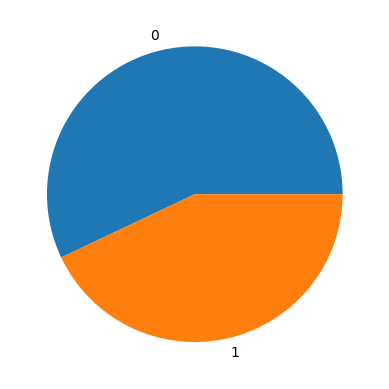

In [7]:
import matplotlib.pyplot as plt

labels = 0,1
sizes = [train['target'].value_counts()[0],train['target'].value_counts()[1]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)

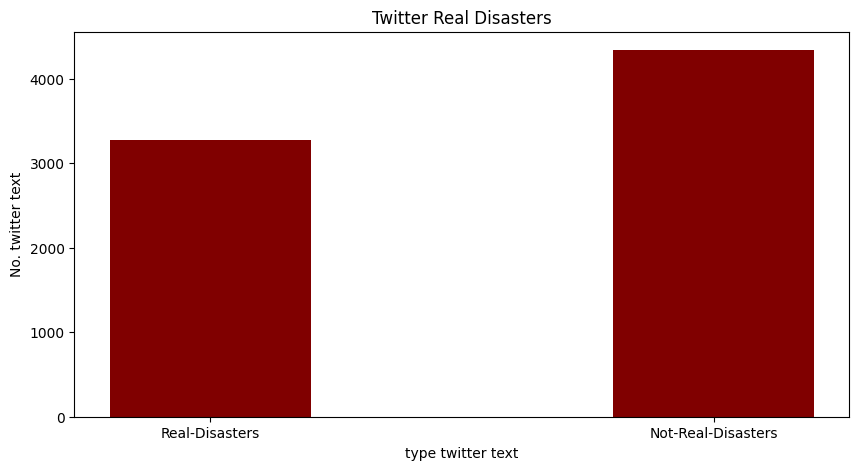

In [8]:
data = {'Real-Disasters': train['target'].value_counts()[1],"Not-Real-Disasters": train['target'].value_counts()[0]}

targets = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(targets, values, color ='maroon', 
        width = 0.4)
 
plt.xlabel("type twitter text")
plt.ylabel("No. twitter text")
plt.title("Twitter Real Disasters")
plt.show()

In [9]:
X = train["text"]
y = train["target"]

In [10]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
max_len = 0

for sent in X:

    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [12]:
input_ids = []
attention_masks = []

for sent in X:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y)

print('Original: ', X[0])
print('Token IDs:', input_ids[0])

Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Token IDs: tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
         2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [13]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,329 training samples
1,522 validation samples


In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

testing_dataloader = DataLoader(
            test_dataset, 
            sampler = SequentialSampler(test_dataset), 
            batch_size = batch_size 
        )

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [17]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [18]:
import numpy as np
import time
import datetime


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [19]:
model.cuda()
seed_val = 42
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = "cuda" if torch.cuda.is_available() else "cpu"
device 

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    t0 = time.time()
    
    total_train_loss = 0
    total_train_acc = 0
    
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()
        
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        
        loss = output.loss
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_train_loss += loss.item()
        total_train_acc += flat_accuracy(logits, label_ids)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_acc = total_train_acc / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    model.eval()
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

            loss = output.loss
            logits = output.logits
        
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Accur.': avg_train_acc,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    167.    Elapsed: 0:00:24.
  Batch    80  of    167.    Elapsed: 0:00:46.
  Batch   120  of    167.    Elapsed: 0:01:10.
  Batch   160  of    167.    Elapsed: 0:01:33.

  Average training loss: 0.48
  Training epcoh took: 0:01:37

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.42
  Validation took: 0:00:10

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    167.    Elapsed: 0:00:24.
  Batch    80  of    167.    Elapsed: 0:00:48.
  Batch   120  of    167.    Elapsed: 0:01:13.
  Batch   160  of    167.    Elapsed: 0:01:38.

  Average training loss: 0.33
  Training epcoh took: 0:01:43

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.41
  Validation took: 0:00:11

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    167.    Elapsed: 0:00:25.
  Batch    80  of    167.    Elapsed: 0:00:51.
  Batch   120  of    167.    Elapsed: 0:01:16.
  Batch   160  of    167.    Elapsed: 0:01:42.



In [20]:
df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Accur.,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,0.781712,0.476775,0.417573,0.821542,0:01:37,0:00:10
2,0.869617,0.333567,0.409267,0.829210,0:01:43,0:00:11
3,0.908683,0.250950,0.479389,0.829355,0:01:46,0:00:11
4,0.929454,0.194301,0.514832,0.825448,0:01:47,0:00:11


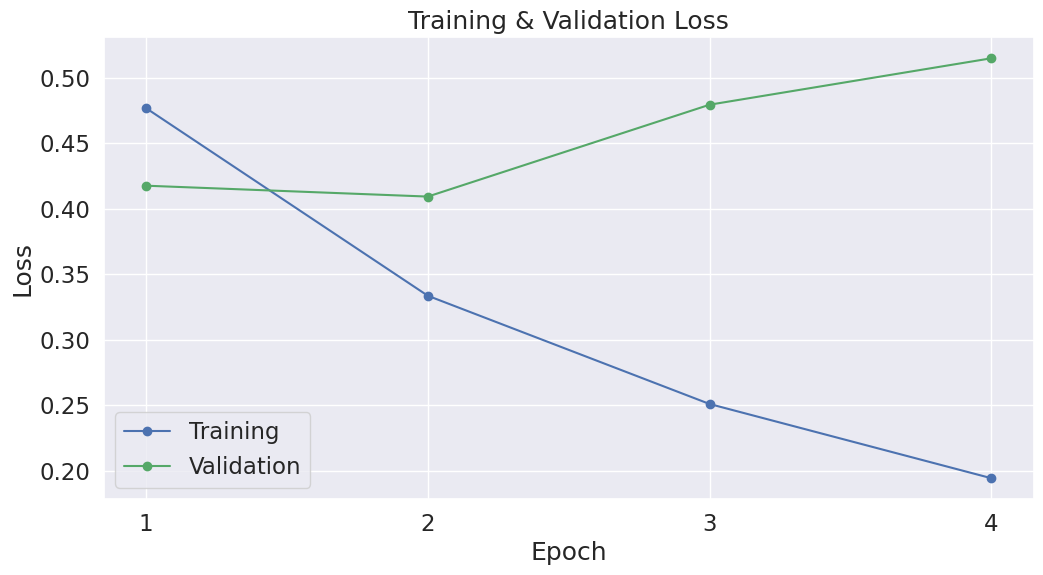

In [21]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

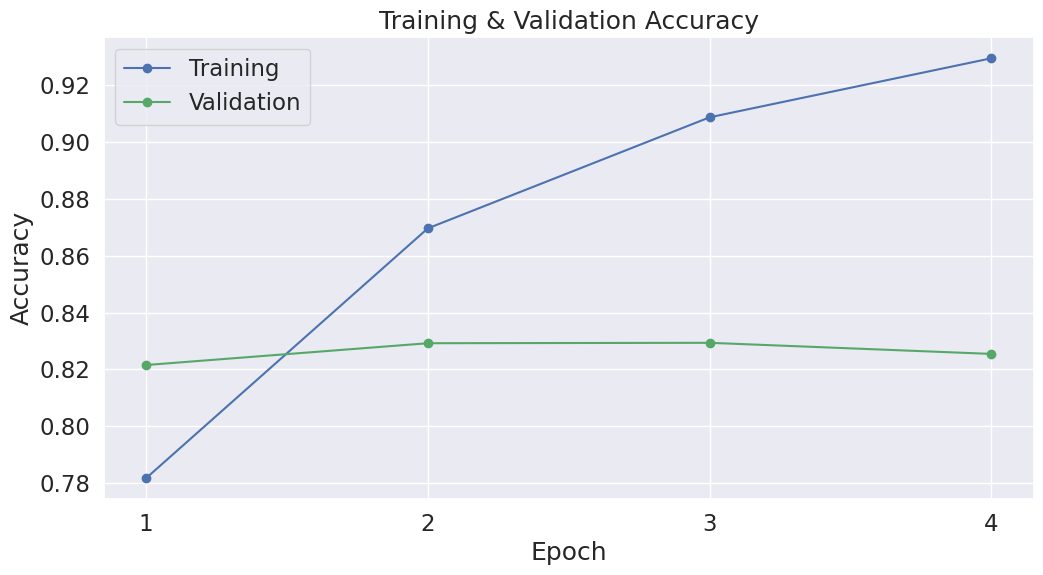

In [22]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Accur.'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")

plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [23]:
model.eval()

predictions, true_labels = [], []

for batch in testing_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

In [24]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

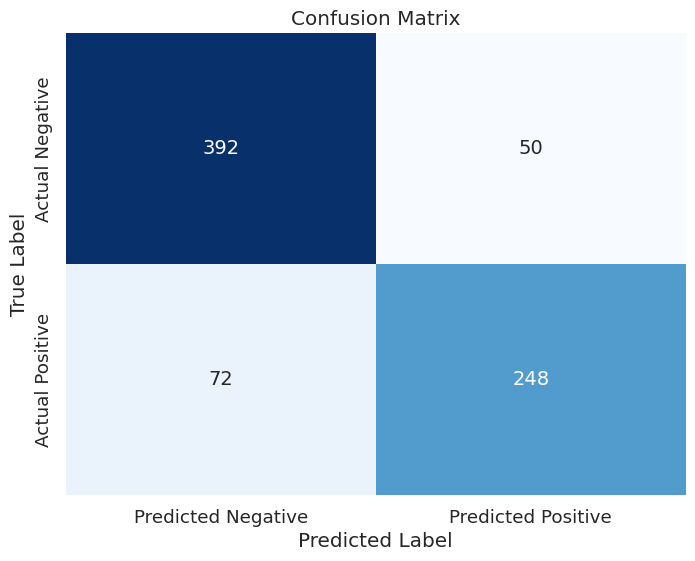

In [25]:
conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Set font scale
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            annot_kws={"size": 14}, cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [26]:
print(classification_report(flat_true_labels,flat_predictions))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       442
           1       0.83      0.78      0.80       320

    accuracy                           0.84       762
   macro avg       0.84      0.83      0.83       762
weighted avg       0.84      0.84      0.84       762



In [27]:
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [28]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [29]:
sentences_test_set = test.text.values

In [30]:
input_ids = []
attention_masks = []

for sent in sentences_test_set:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

batch_size = 32

test_data = TensorDataset(input_ids, attention_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [31]:
model.eval()

predictions_test = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()

    predictions_test.append(logits)

flat_predictions_test = np.concatenate(predictions_test, axis=0)

flat_predictions_test = np.argmax(flat_predictions_test, axis=1).flatten()

In [32]:
results_test_set = {'id': test['id'],
        'target': flat_predictions_test
        }
df = pd.DataFrame(results_test_set)

In [33]:
df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [34]:
df.to_csv('submission.csv', index=False)